[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/whyhardt/SPICE/blob/main/tutorials/3_hardcoded_equations.ipynb)

# Working with Hardcoded Equations

This tutorial explains how to use predefined equations in SPICE models. You'll learn how to:
- Incorporate known cognitive mechanisms as hardcoded equations
- Combine hardcoded equations with learned mechanisms
- Optimize model performance using domain knowledge

### Prerequisites

Before starting this tutorial, make sure you have:
- Completed the previous tutorials
- Understanding of basic cognitive modeling equations

### Why Use Hardcoded Equations?

Sometimes we have strong theoretical knowledge about certain cognitive mechanisms. For example:
- The reward prediction error in reinforcement learning
- Memory decay functions in forgetting models
- Attention mechanisms in decision making

Using hardcoded equations allows us to:
1. Incorporate established theoretical knowledge
2. Reduce the search space for model discovery
3. Focus learning on unknown mechanisms

### Reward Prediction Error

In the previous tutorial, the equation for `x_reward_value_chosen` resembled the reward-prediction error.

The reward-prediction error is fairly well understood in cognitive science - also thanks to neuroimaging studies, which underlie the assumption about the classic mathematical form.

Therefore, the possible novel findings are quite limited here.

The learning rate on the other hand is in many studies assumed to be a constant and is also embedded in the SPICE-discovered equation as a fixed parameter.
It can of course model asymmetric learning rates for rewards and penalties but is not adapting dynamically.

So what if we would like to find a dynamical equation which describes how the learning rate could possibly change with respect to rewards or the current value `x_reward_value_chosen`?

The problem here is that we cannot just add another RNN-module in-line with `x_reward_value_chosen` which processes the same inputs.

This would result in two modules which would not have unique solutions.

Therefore, we have to disentangle here by adding knowledge about `x_reward_value_chosen` in the form of the classic reward-prediction error.

That way we are ending up with an additional RNN-module in the form of a hard-coded equation, and we have to expand the memory state by one variable which is the learning rate `x_learning_rate_reward`.

Additionally, we are going to set the initial values for all memory state variables.

In the next section you will learn how to add the reward prediction error mechanism as a hard-coded equation to the RNN.

As usual, we first start with the precoded model and then show how to implement it.

## 1. Data generation

Again, we simulate another synthetic dataset from a Q-learning agent.

In [1]:
# Uncomment the code below and execute the cell if you are using Google Colab

#!pip uninstall -y numpy pandas
#!pip install numpy==1.26.4 pandas==2.2.2

In [2]:
# Uncomment the code below and execute the cell if you are using Google Colab

#!pip install autospice

In [3]:
import numpy as np
import torch

np.random.seed(42)
torch.manual_seed(42)

In [4]:
from spice.resources.bandits import BanditsDrift, AgentQ, create_dataset

# Set up the environment
n_actions = 2
sigma = 0.2

environment = BanditsDrift(sigma=sigma, n_actions=n_actions)

# Set up the agent
agent = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.3,
    forget_rate=0.2,
)

# Create the dataset
n_trials = 100
n_sessions = 100

dataset, _, _ = create_dataset(
    agent=agent,
    environment=environment,
    n_trials=n_trials,
    n_sessions=n_sessions,
)

# set all participant ids to 0 since this dataset was generated only by one parameterization
dataset.xs[..., -1] = 0

/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creating dataset...


100%|██████████| 100/100 [00:03<00:00, 28.04it/s]


## 2. Using the precoded model with hardcoded equation

We first load the precoded model, which has the reward prediction error equation hardcoded as one of its modules. Additionally, it has an additional RNN module for the learning rate.

*Note: Only SINDy-fitted modules are printed when calling `SpiceEstimator.print_spice_models()`*

In [5]:
from spice.estimator import SpiceEstimator
from spice.precoded import LearningRateRNN, LEARNING_RATE_RNN_CONFIG

spice_estimator = SpiceEstimator(
    rnn_class=LearningRateRNN,
    spice_config=LEARNING_RATE_RNN_CONFIG,
    learning_rate=1e-2,
    epochs=1024,
)

spice_estimator.fit(dataset.xs, dataset.ys)

spice_estimator.print_spice_model()


Training the RNN...
Epoch 1024/1024 --- L(Train): 0.6050525; Time: 0.16s; Convergence: 1.18e-07
Maximum number of training epochs reached.


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

SPICE modules:
(x_learning_rate_reward)[k+1] = 0.359 1
(x_value_reward_not_chosen)[k+1] = 0.101 1 + 0.803 x_value_reward_not_chosen[k]
beta(x_value_reward) = 2.5988


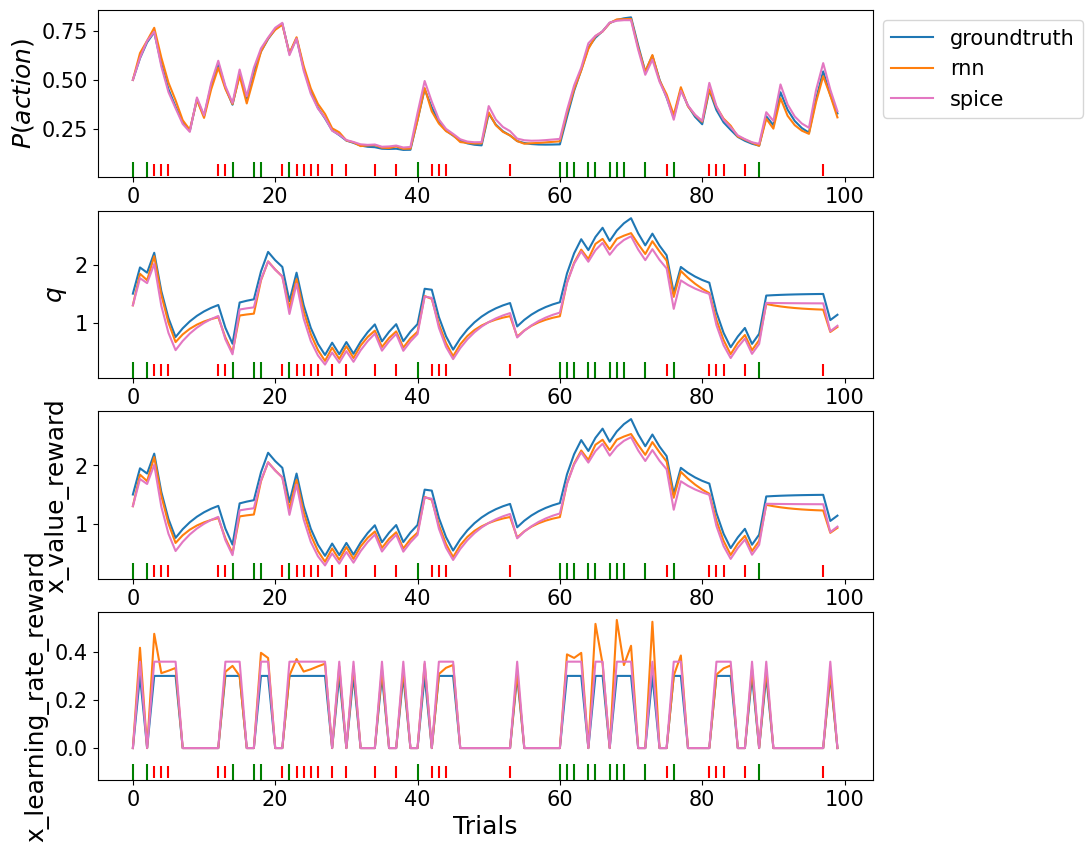

In [6]:
from spice.utils.plotting import plot_session
import matplotlib.pyplot as plt

# get analysis plot
agents = {'groundtruth': agent, 'rnn': spice_estimator.rnn_agent, 'spice': spice_estimator.spice_agent}

fig, axs = plot_session(agents, dataset.xs[0], signals_to_plot=['x_value_reward', 'x_learning_rate_reward'])
plt.show()

Now that we are making use of the established theories about the reward-prediction error in human reinforcement learning, we were able to to shift our focus on a less understood area i.e. the learning rate. In this example, the synthetic participant does not exhibit real dynamics in the sense of $\alpha_{t+1} = f(\alpha_{t})$, but the network is in principle equipped to learn also such a mechanism.

## 3. Implementing the RNN as a custom module

Now, we are going to implement the RNN that discovers RW model with a forgetting mechanism. This RNN will update the values of both the chosen and not chosen option, as in the previous tutorial. But instead of updating the value of the chosen option directly via an RNN-module, we are now going to estimate the learning rate as a dynamical system and update the value via a hard-coded equation, the reward-prediction-error.

Since we cannot estimate the learning rate AND the update function of the chosen value due to their bidirectional dependency, we can determine the object of interest (i.e. the learning rate) that way.

The structure of this RNN is shown in the following figure:

![](../figures/spice_rnn_hardcoded.png)

As you can see we are going to add one module which won't be an RNN-module but instead a hard-coded equation. The learning rate on the other hand will be updated via an additional RNN-module. 

In [7]:
from spice.resources.rnn import BaseRNN
from spice.estimator import SpiceConfig

CUSTOM_RNN_CONFIG = SpiceConfig(
    rnn_modules=['x_learning_rate_reward', 'x_value_reward_not_chosen'],
    
    control_parameters=['c_action', 'c_reward', 'c_value_reward'],

    library_setup={
        'x_learning_rate_reward': ['c_reward', 'c_value_reward'],
        'x_value_reward_not_chosen': [],
    },

    filter_setup={
        'x_learning_rate_reward': ['c_action', 1, True],
        'x_value_reward_not_chosen': ['c_action', 0, True],
    },
)

class CustomLearningRateRNN(BaseRNN):
    
    init_values = {
            'x_value_reward': 0.5,
            'x_learning_rate_reward': 0,  # NOTE: 1st major change -> extended memory state with learning rate
    }
    
    def __init__(
        self,
        n_actions,
        **kwargs,
    ):
        super(CustomLearningRateRNN, self).__init__(n_actions=n_actions)
        
        # set up the submodules
        self.submodules_rnn['x_learning_rate_reward'] = self.setup_module(input_size=2)  # NOTE: 2nd major change -> Replaced the module 'x_value_reward_chosen' with the learning rate module 'x_learning_rate_reward'
        self.submodules_rnn['x_value_reward_not_chosen'] = self.setup_module(input_size=0)

        # set up hard-coded equations
        # add here a RNN-module in the form of an hard-coded equation to compute the update for the chosen reward-based value
        self.submodules_eq['x_value_reward_chosen'] = lambda value, inputs: value + inputs[..., 1] * (inputs[..., 0] - value)  # NOTE: 3rd major change -> Added a hard-coded equation for the replaced module 'x_value_reward_chosen', i.e. the reward-prediction-error

        # NOTE: 4th major change -> added a learnable scaling factor (i.e. inverse noise temperature) for 'x_value_reward'
        self.betas['x_value_reward'] = self.setup_constant()
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, ids, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, _, _ = inputs
                
        for timestep, action, reward in zip(timesteps, actions, rewards):
            
            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
            self.record_signal('c_value_reward', self.state['x_value_reward'])
            self.record_signal('x_value_reward_not_chosen', self.state['x_value_reward'])
            self.record_signal('x_learning_rate_reward', self.state['x_learning_rate_reward'])
            
            # Let's compute the learning rate dynamically
            # Now we have to use a sigmoid activation function on the output learning rate to constrain it to a value range of (0, 1)
            # this is necessary for two reasons:
            #   1. Preventing exploding gradients
            #   2. Remember the found equation for 'x_value_reward_chosen' from before: 
            #       The learning rate was scaled according to the magnitudes of the reward and the actual value 
            #       e.g. for the reward: alpha*beta -> alpha * beta = 0.3 * 3 = 0.9 and for the reward-based value: 1-alpha = 1 - 0.3 = 0.7
            #       The hard-coded equation for the reward-prediction error does not permit this flexibility. 
            #       But we can circumvein this by applying the sigmoid activation to the learning rate to staying conform with the reward-prediction error
            #       and later applying the inverse noise temperature (i.e. trainable parameter) to the updated value 
            learning_rate_reward = self.call_module(
                key_module='x_learning_rate_reward',
                key_state='x_learning_rate_reward',
                action=action,
                inputs=(reward, self.state['x_value_reward']),
                activation_rnn=torch.nn.functional.sigmoid,
            )
            
            # Let's perform the belief update for the reward-based value of the chosen option            
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward_chosen',
                key_state='x_value_reward',
                action=action,
                inputs=(reward, learning_rate_reward),
                )
            
            # Update of the not-chosen reward-based value
            next_value_reward_not_chosen = self.call_module(
                key_module='x_value_reward_not_chosen',
                key_state='x_value_reward',
                action=1-action,
                inputs=None,
                )
            
            # updating the memory state
            self.state['x_learning_rate_reward'] = learning_rate_reward
            self.state['x_value_reward'] = next_value_reward_chosen + next_value_reward_not_chosen
            
            # Now keep track of the logit in the output array
            logits[timestep] = self.state['x_value_reward'] * self.betas['x_value_reward']()
        
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        logits = self.post_forward_pass(logits, batch_first)
        
        return logits, self.get_state()